In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
scaler = MinMaxScaler(feature_range=(-1, 1))

pf = pd.read_csv('data/Google_Stock_Price_Train.csv')
pf_test = pd.read_csv('data/Google_Stock_Price_Test.csv')

pf_test['Volume'] = pf_test['Volume'].str.replace(',','').astype(float)

pf['Volume'] = pf['Volume'].str.replace(',','').astype(float)
pf['Close'] = pf['Close'].str.replace(',','').astype(float)

In [2]:
head_names = list(pf.columns.values)[1:]
head_names_original = head_names.copy()

In [3]:
def split_data(volume, sequence_size, M):
    data = []
    for index in range(len(volume.to_numpy())-sequence_size): 
        data.append(volume.to_numpy()[index: index+sequence_size])
    data = np.array(data)
    
    vali_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (vali_set_size)
    m = -1-M
    
    x_train = data[:train_set_size ,: -1 ,:]
    y_train = data[:train_set_size ,m:-1,:]
    x_vali = data[train_set_size :,: -1]
    y_vali = data[train_set_size:, m:-1,:]
    
    
    y_train_holder = []
    for i in range(len(y_train)):
        k = []
        for n in range(M):
            k.append(y_train[i][n][:])
        y_train_holder.append(k)
        
    y_vali_holder = []
    for i in range(len(y_vali)):
        k = []
        for n in range(M):
            k.append(y_vali[i][n][:])
        y_vali_holder.append(k)
    
    y_vali, y_train = np.array(y_vali_holder), np.array(y_train_holder)
    return [x_train, y_train, x_vali, y_vali]

In [4]:
def test_data(volume, sequence_size, M):
    data = []
    for index in range(len(volume.to_numpy())-sequence_size): 
        data.append(volume.to_numpy()[index: index+sequence_size])
    data = np.array(data)
    m = -1-M
    x_vali = data[:,: -1]
    y_vali = data[:, m:-1,:]
    y_vali_holder = []
    for i in range(len(y_vali)):
        k = []
        for n in range(M):
            k.append(y_vali[i][n][:])
        y_vali_holder.append(k)
    y_vali= np.array(y_vali_holder)
    return [x_vali, y_vali]

In [5]:
pf_test_head_names = list(pf_test.columns.values)[1:]
pf_test_head_names_original = head_names.copy()
pf_test = pf_test[pf_test_head_names_original]
for i in pf_test_head_names_original:
    pf_test[i] = scaler.fit_transform(pf_test[i].values.reshape(-1,1))
# pf_test

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, input_sequence,M):
#         print('x.shape',x.shape)
        h = torch.zeros(self.num_layers, input_sequence.size(0), self.hidden_dim).requires_grad_()
#         print('h0.shape',h0.shape)
        c = torch.zeros(self.num_layers, input_sequence.size(0), self.hidden_dim).requires_grad_()
#         print('c0.shape',c0.shape)
        out, (hh, cc) = self.lstm(input_sequence, (h.detach(), c.detach()))
#         print('out.shape',out.shape)
        out = self.fc(out[:, -1, :]) 
        out = out.reshape(-1,M,5)
#         print('self.fc(out[:, -1, :]).shape',out.shape)
        return out

In [7]:
def calculate(volume, N, M, num_epochs, num_layers, col_name, x_train, x_vali, y_train_lstm, y_vali_lstm):
    x_train = torch.tensor(x_train).float()
    x_vali = torch.tensor(x_vali).float()
    y_train_lstm = torch.tensor(y_train_lstm).float()
    y_vali_lstm = torch.tensor(y_vali_lstm).float()
    
    input_size = volume.shape[1]
    hidden_layer_size = N * input_size
    output_size = M*5
    
    model = LSTM(input_dim=input_size, hidden_dim=hidden_layer_size, output_dim=output_size, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    
    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    y_train_pred = []
    loss = 0
    for t in range(num_epochs):
        y_train_pred = model(x_train,M)
#         print('y_train_pred',y_train_pred)
#         print('y_train_lstm',y_train_lstm)
#         print('y_train_pred.shape',y_train_pred.shape)
#         print('y_train_lstm.shape',y_train_lstm.shape)
        loss = criterion(y_train_pred, y_train_lstm)
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print("Epoch ", num_epochs, "MSE: ", loss.item())
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    
    y_train_lstm_plot = y_train_lstm.tolist()
    y_train_pred_plot = y_train_pred.tolist()
    
    pred_vali = model(x_vali,M)
    pred_vali_plot = pred_vali.tolist()
    y_vali_lstm_plot = y_vali_lstm.tolist()
    loss_rate = hist
    return y_train_lstm_plot, y_train_pred_plot, pred_vali_plot, y_vali_lstm_plot,loss_rate, model
    


In [8]:
# def test_plots_and_calculation(pf_test, N, M, model, epochs_list):
#     x_test, y_test = test_data(pf_test, N, M)
#     y_test = torch.tensor(y_test).float()
#     x_test = torch.tensor(x_test).float()

    
    
    
    
#     y_test_pred = model(x_test,M)
#     y_test_pred = y_test_pred.tolist()
#     y_test_plot = y_test.copy().tolist()
# #     y_test_pred = torch.tensor(y_test_pred).float()
# #     y_test_plot = torch.tensor(y_test_plot).float()
    
    
#     pred_vali = model(x_test,M)
#     pred_vali_plot = pred_vali.tolist()
# #     y_vali_lstm_plot = y_vali_lstm.tolist()
# #     loss_rate = hist
    
    
    
    
#     x = []
#     for i in range(len(pf_test)):
#         x.append(i)
#     fig = plt.figure(figsize=(10, 30))
#     counter = 0
#     for h in range(len(head_names)):
#         for t in range(len(pred_vali_plot[h])):
#             temp = 0
#             for q in range(M):
#                 temp += (1/M)*pred_vali_plot[h][t][q][h]
#             pred_vali_plot[h][t] = temp
#         for t in range(len(y_test_plot[h])):
#             temp = 0
#             for q in range(M):
#                 temp += (1/M)*y_test_plot[h][t][q][h]
#             y_test_plot[h][t] = temp
    
    
    
    
    
#     counter = 0
#     print('------------testing plots----------')
#     for i in range(len(head_names)):
#         counter+=1
#         ax = plt.subplot(len(head_names)*2, 2, counter)
#         title = 'Testing: epoch: '+ str(epochs_list)+' M: '+str(M)+' N: '+str(N)+ ' num_layers: '+str(num_layers)
#         ax.set_title(title)
#         plt.plot(x,y_test_plot[i], label = head_names[i]+' original')
#         plt.plot(x,pred_vali_plot[i], label = head_names[i]+' predict')
#         x_learning_curve = []
#         plt.legend()
#         plt.tight_layout()
#     plt.legend()
    
    
    
    
    
# test_plots_and_calculation(pf_test, N, M, model, epochs_list)
    
    

<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  10 MSE:  0.13730041682720184
Training time: 0.1868579387664795
Epoch  10 MSE:  0.08736322820186615
Training time: 0.18779921531677246
Epoch  10 MSE:  0.10844407975673676
Training time: 0.1365208625793457
Epoch  10 MSE:  0.09815128147602081
Training time: 0.13833308219909668
Epoch  10 MSE:  0.08576122671365738
Training time: 0.15332603454589844
------------Validation plots----------


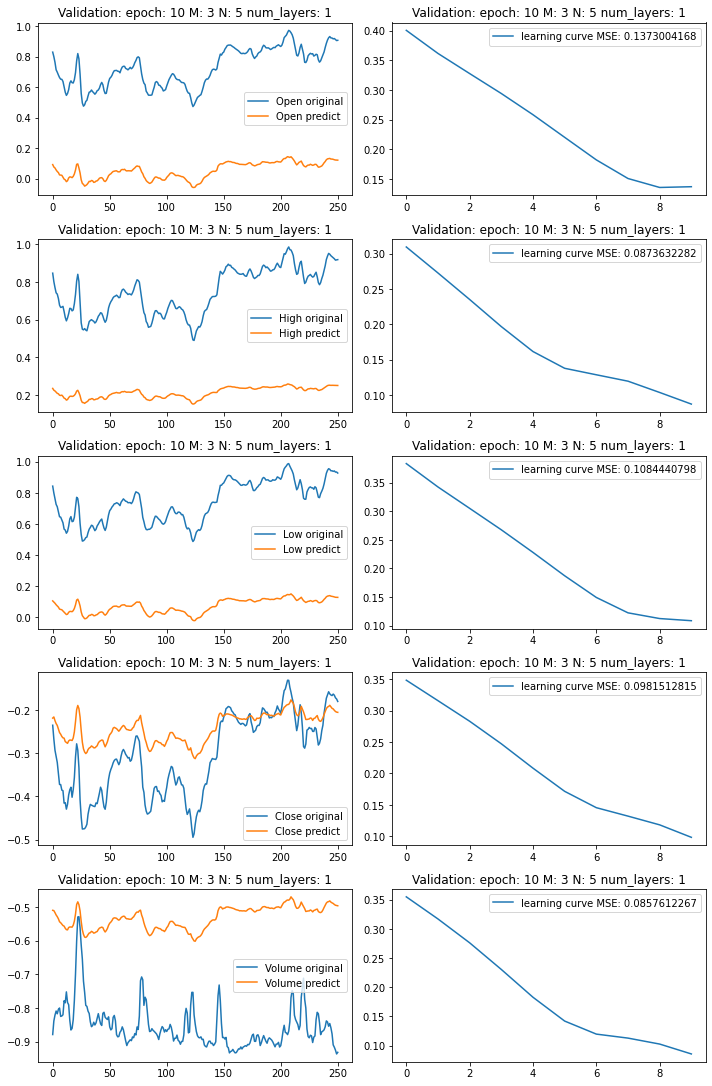

In [9]:
def hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list):
    num_epochs = epochs_list
    y_train_lstm_list, y_train_pred_list, pred_vali_plot_list, y_vali_lstm_plot_list, loss_rate_list = [], [], [], [], []
    for i in head_names:
        pf[i] = scaler.fit_transform(pf[i].values.reshape(-1,1))
    volume = pf[head_names_original]
    x_train, y_train, x_vali, y_vali = split_data(volume, N, M)
    x_train = torch.tensor(x_train).float()
    x_vali = torch.tensor(x_vali).float()
    y_train_lstm = torch.tensor(y_train).float()
    y_vali_lstm = torch.tensor(y_vali).float()
    i ='k'
    for i in head_names:
        y_train_lstm, y_train_pred, pred_vali_plot, y_vali_lstm_plot, loss_rate, model = calculate(volume, N, 
        M, num_epochs, num_layers, i, x_train, x_vali, y_train_lstm, y_vali_lstm)
#     print('y_train_lstm',y_train_lstm)
#     for i in head_names:
        y_train_lstm_list.append(y_train_lstm)
        y_train_pred_list.append(y_train_pred)
        loss_rate_list.append(loss_rate)
        pred_vali_plot_list.append(pred_vali_plot) 
        y_vali_lstm_plot_list.append(y_vali_lstm_plot)
    x = []

    for i in range(len(y_vali_lstm_plot_list[0])):
        x.append(i)
    fig = plt.figure(figsize=(10, 30))
    counter = 0
    for h in range(len(head_names)):
        for t in range(len(y_vali_lstm_plot_list[h])):
            temp = 0
            for q in range(M):
#                 print('h',h,'t',t)
#                 print('y_vali_lstm_plot_list[1][0]1',y_vali_lstm_plot_list[1][0])
                temp += (1/M)*y_vali_lstm_plot_list[h][t][q][h]
#             print('temp',temp)
#             print('y_vali_lstm_plot_list[1][0]2',y_vali_lstm_plot_list[1][0])
#             print('h,t',h,t)
#             print('y_vali_lstm_plot_list[h][t]1 = ',y_vali_lstm_plot_list[h][t])
            y_vali_lstm_plot_list[h][t] = temp
#             print('y_vali_lstm_plot_list[h][t]2 = ',y_vali_lstm_plot_list[h][t])
#             print('y_vali_lstm_plot_list[1][0]3',y_vali_lstm_plot_list[1][0])
        for t in range(len(pred_vali_plot_list[h])):
            temp = 0
            for q in range(M):
                temp += (1/M)*pred_vali_plot_list[h][t][q][h]
            pred_vali_plot_list[h][t] = temp
                
    print('------------Validation plots----------')
    for i in range(len(head_names)):
        counter+=1
        ax = plt.subplot(len(head_names)*2, 2, counter)
        title = 'Validation: epoch: '+ str(epochs_list)+' M: '+str(M)+' N: '+str(N)+ ' num_layers: '+str(num_layers)
        ax.set_title(title)
        plt.title = head_names[i]
        
        plt.plot(x,y_vali_lstm_plot_list[i], label = head_names[i]+' original')
        plt.plot(x,pred_vali_plot_list[i], label = head_names[i]+' predict')
        x_learning_curve = []
        plt.legend()
        counter+=1
        for k in range(len(loss_rate_list[i])):
            x_learning_curve.append(k)
        ax = plt.subplot(len(head_names)*2, 2, counter)
        title = 'Validation: epoch: '+ str(epochs_list)+' M: '+str(M)+' N: '+str(N)+ ' num_layers: '+str(num_layers)
        ax.set_title(title)
        plt.plot(x_learning_curve, loss_rate_list[i], label = 'learning curve MSE: '+str(round(loss_rate_list[i][-1], 10)))
        plt.legend()
        plt.tight_layout()
    plt.legend()
    
    return y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list
N = 5
M = 3

num_layers = 1
use_all_data = True
epochs_list = 10
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  20 MSE:  0.031071163713932037
Training time: 0.23652076721191406
Epoch  20 MSE:  0.036117345094680786
Training time: 0.22879576683044434
Epoch  20 MSE:  0.03564050421118736
Training time: 0.23402190208435059
Epoch  20 MSE:  0.053589049726724625
Training time: 0.23288989067077637
Epoch  20 MSE:  0.03019772842526436
Training time: 0.23001694679260254
------------Validation plots----------


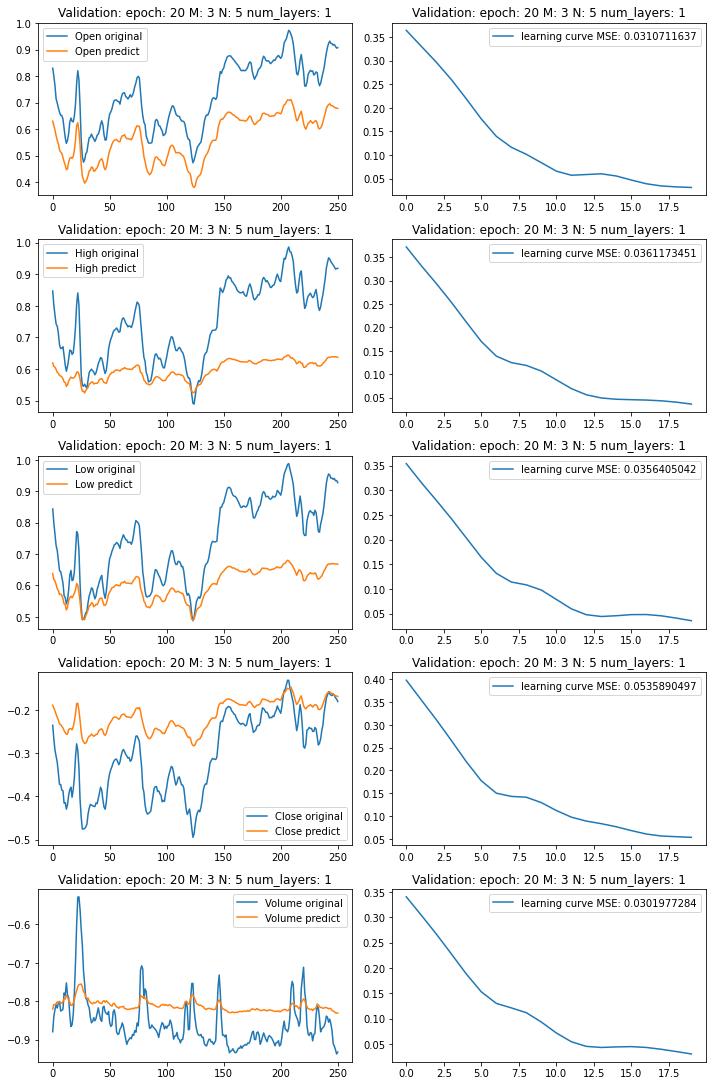

In [10]:
N = 5
M = 3

num_layers = 1
use_all_data = True
epochs_list = 20
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  30 MSE:  0.01329832710325718
Training time: 0.35396575927734375
Epoch  30 MSE:  0.012566639110445976
Training time: 0.35437631607055664
Epoch  30 MSE:  0.011538212187588215
Training time: 0.34433674812316895
Epoch  30 MSE:  0.016758674755692482
Training time: 0.3444070816040039
Epoch  30 MSE:  0.00982618797570467
Training time: 0.35224390029907227
------------Validation plots----------


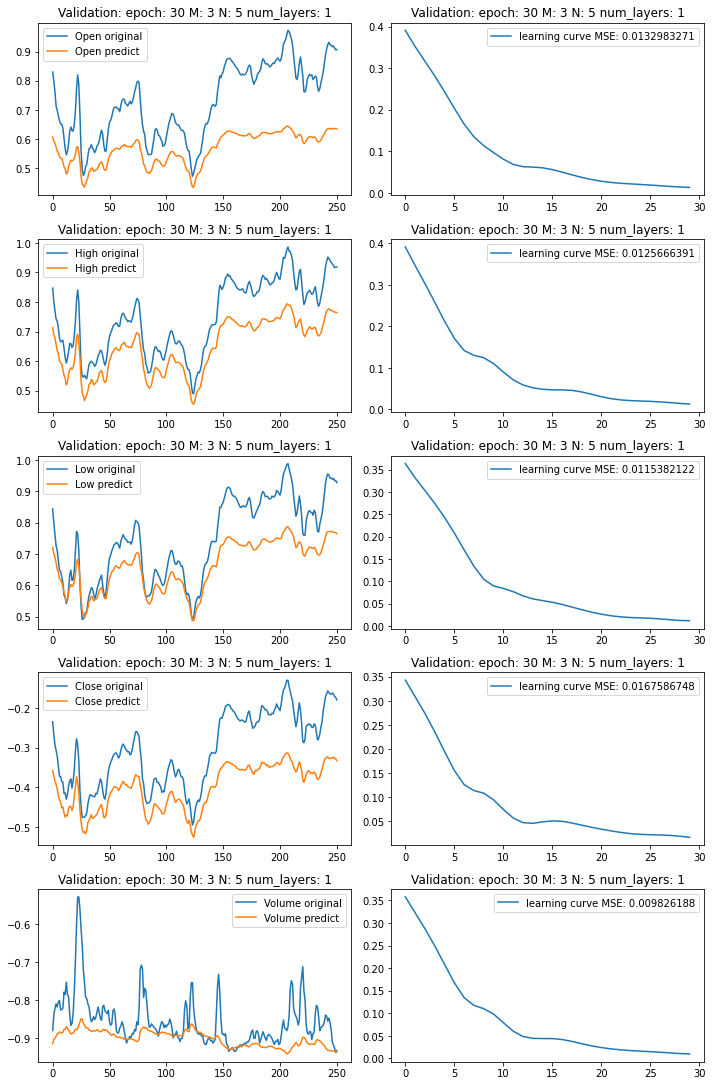

In [11]:
N = 5
M = 3

num_layers = 1
use_all_data = True
epochs_list = 30
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)




<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  50 MSE:  0.0057259490713477135
Training time: 0.57759690284729
Epoch  50 MSE:  0.006208714563399553
Training time: 0.5690691471099854
Epoch  50 MSE:  0.006241504102945328
Training time: 0.5734577178955078
Epoch  50 MSE:  0.0063898153603076935
Training time: 0.578387975692749
Epoch  50 MSE:  0.006758588366210461
Training time: 0.6286919116973877
------------Validation plots----------


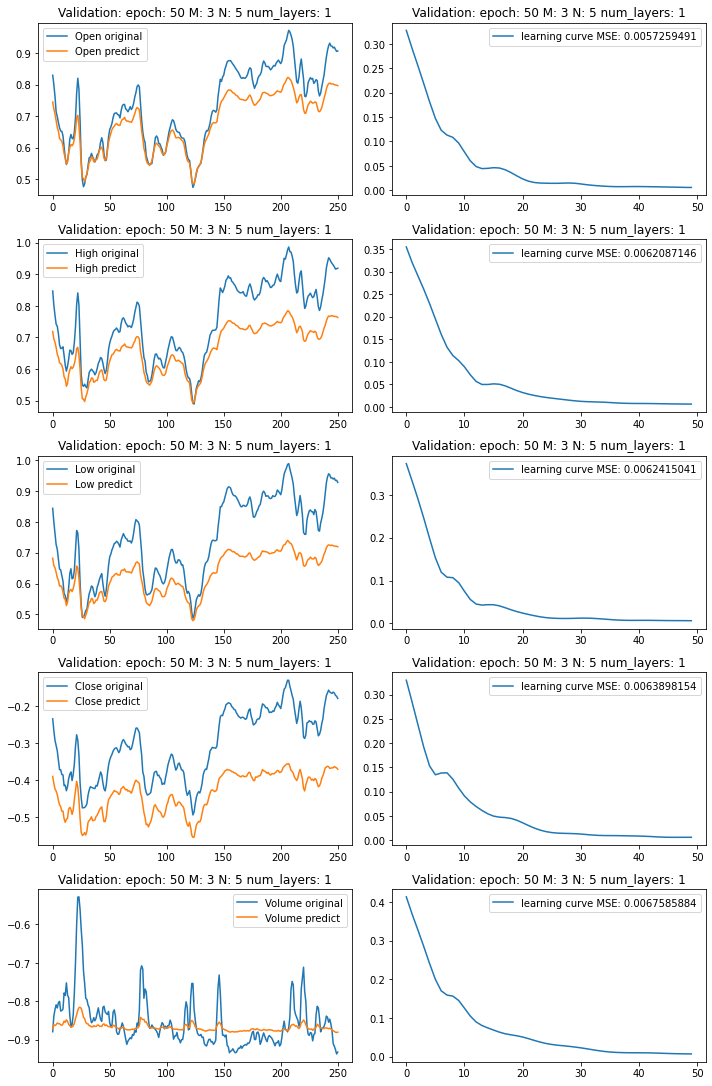

In [12]:
N = 5
M = 3

num_layers = 1
use_all_data = True
epochs_list = 50
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  100 MSE:  0.00381195149384439
Training time: 1.181995153427124
Epoch  100 MSE:  0.004012576304376125
Training time: 1.3504230976104736
Epoch  100 MSE:  0.004490254912525415
Training time: 1.2038209438323975
Epoch  100 MSE:  0.003911247476935387
Training time: 1.2440640926361084
Epoch  100 MSE:  0.0041183773428201675
Training time: 1.160167932510376
------------Validation plots----------


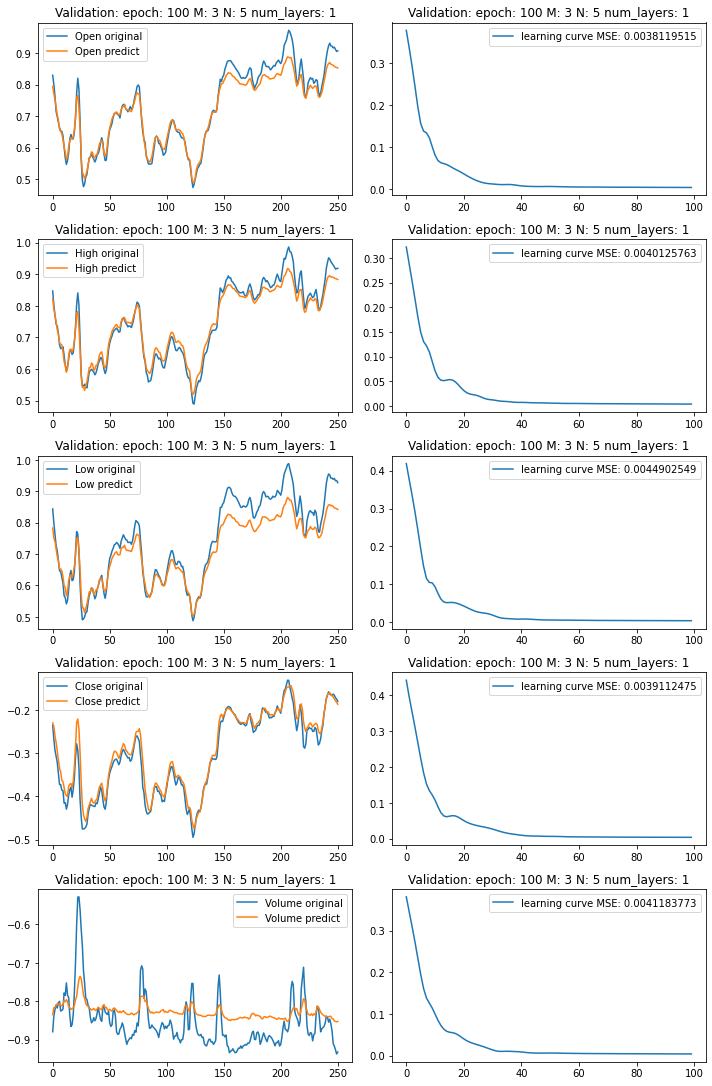

In [13]:
N = 5
M = 3

num_layers = 1
use_all_data = True
epochs_list = 100
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  200 MSE:  0.0028532519936561584
Training time: 1.949390172958374
Epoch  200 MSE:  0.0026465316768735647
Training time: 2.3540072441101074
Epoch  200 MSE:  0.0028034227434545755
Training time: 2.3390138149261475
Epoch  200 MSE:  0.0027581199537962675
Training time: 2.319093942642212
Epoch  200 MSE:  0.00292266090400517
Training time: 2.3722259998321533
------------Validation plots----------


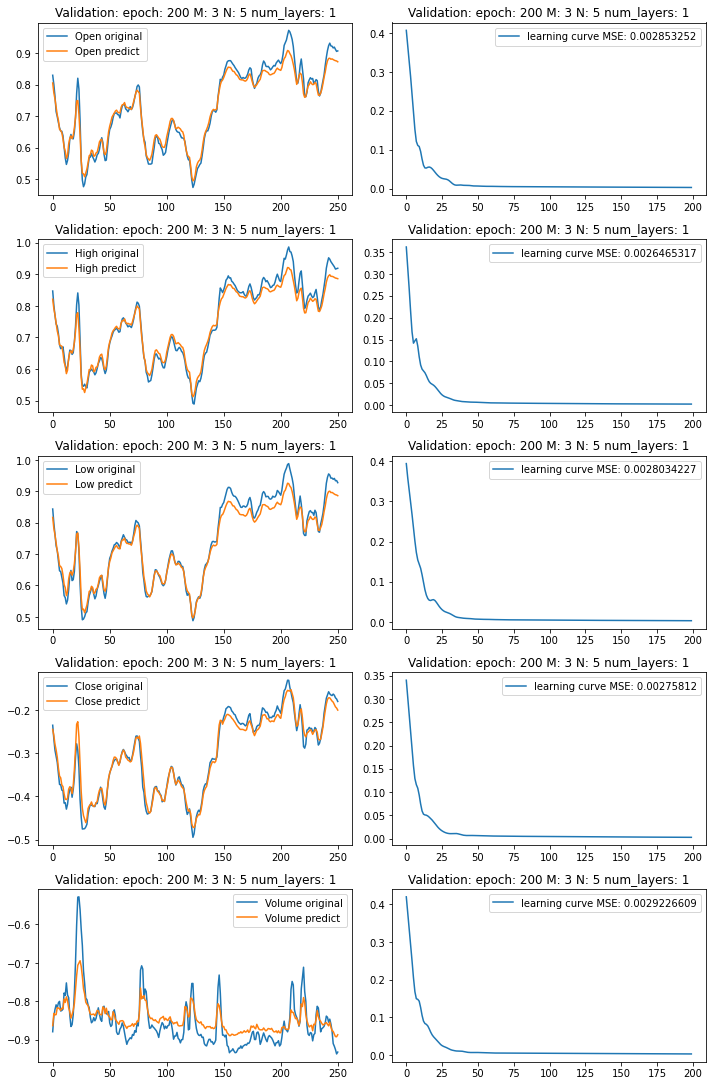

In [14]:
N = 5
M = 3

num_layers = 1
use_all_data = True
epochs_list = 200
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  500 MSE:  0.0010201944969594479
Training time: 5.819395065307617
Epoch  500 MSE:  0.0009741232497617602
Training time: 5.8339619636535645
Epoch  500 MSE:  0.0008041913388296962
Training time: 5.7603371143341064
Epoch  500 MSE:  0.0008286669617518783
Training time: 5.825153112411499
Epoch  500 MSE:  0.0006457532290369272
Training time: 5.907119274139404
------------Validation plots----------


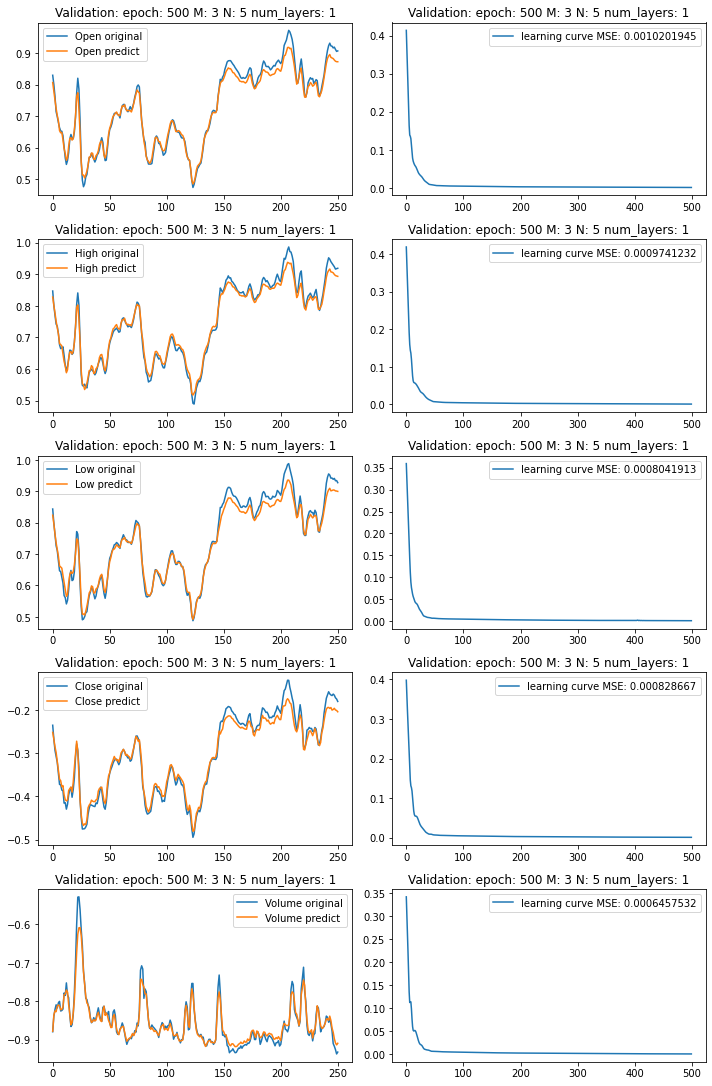

In [15]:
N = 5
M = 3

num_layers = 1
use_all_data = True
epochs_list = 500
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  1000 MSE:  0.00022691854974254966
Training time: 11.59168004989624
Epoch  1000 MSE:  0.0002232367842225358
Training time: 11.445436954498291
Epoch  1000 MSE:  0.00022596797498408705
Training time: 11.55055832862854
Epoch  1000 MSE:  0.0002164944598916918
Training time: 11.575371026992798
Epoch  1000 MSE:  0.00022745163005311042
Training time: 11.287858963012695
------------Validation plots----------


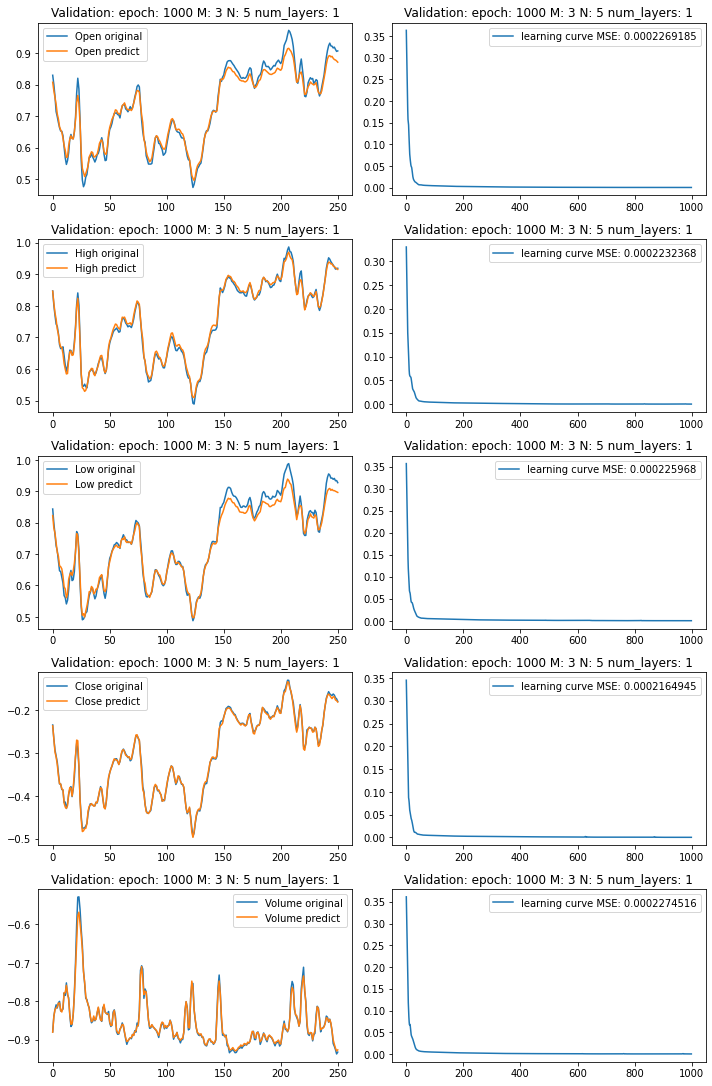

In [16]:
N = 5
M = 3

num_layers = 1
use_all_data = True
epochs_list = 1000
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  3000 MSE:  4.52648127975408e-05
Training time: 34.588181018829346
Epoch  3000 MSE:  5.212081305216998e-05
Training time: 34.67526984214783
Epoch  3000 MSE:  5.8387202443555e-05
Training time: 34.69988393783569
Epoch  3000 MSE:  4.754682959173806e-05
Training time: 35.7677698135376
Epoch  3000 MSE:  3.9724152884446084e-05
Training time: 38.95082497596741
------------Validation plots----------


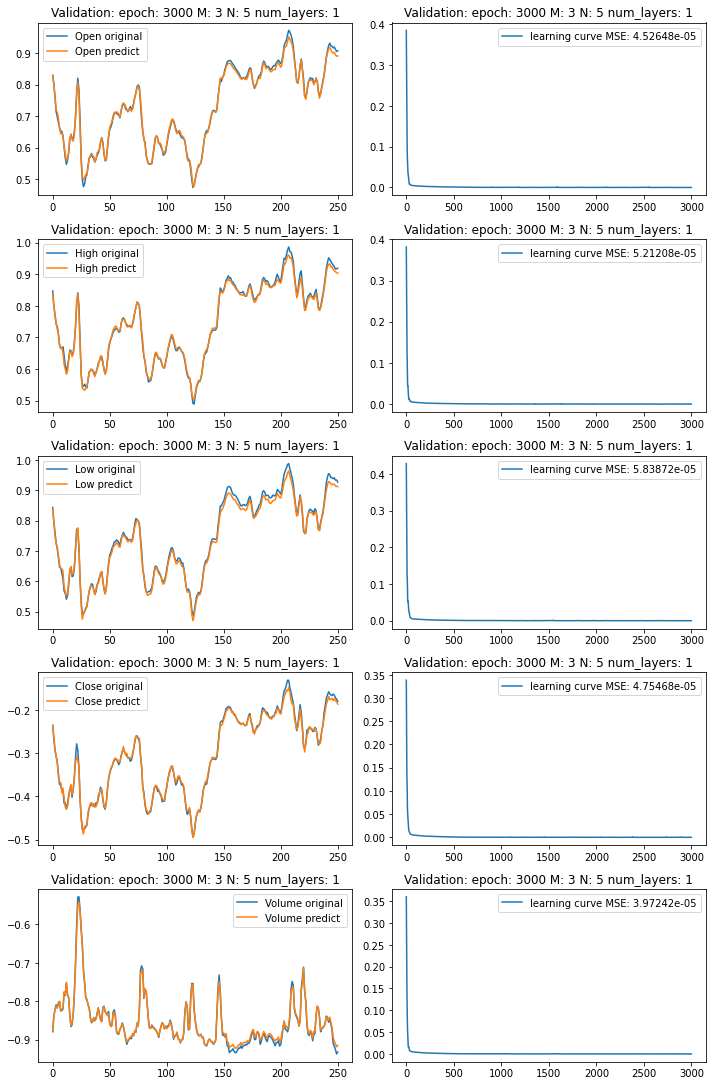

In [17]:
N = 5
M = 3

num_layers = 1
use_all_data = True
epochs_list = 3000
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

# Testing